In [241]:
import os
import time
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from IPython.display import clear_output
from scipy.ndimage.filters import gaussian_filter1d   ## smoother

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.dataset import random_split


from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from albumentations import *
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['image.cmap'] = 'gray'

## Estimating the population of various lineages of cells within the C. elegans embryo using deep learning. 

We would be trying out two approaches:
* The first would be to see how a small model performs on the training and test sets after training
* Then we'd move on to a much larger ResNet18 architecture and see how it performs

### But before that, we'll have to load up the data. 


In [68]:
!cp /content/drive/"My Drive"/data/mini_clean_training_data.csv /content/
!cp /content/drive/"My Drive"/zip/frames_raw.zip /content/
!unzip frames_raw.zip 

## Scaling the training data

Initially, the training ws done on non scled data, and the values of all the populations except the "A" lineage were ranginf from 0 to 20 or so. While A ranged from 0 to  as high as 350. So the model, even after training was able to predict the population of "A" very well, but not the others, because they didn't contribute much to the loss. Not as much as "A" did. 

This was fixed by normalising all the columns within `[-1. ,1.]`, so that all of them contribute equally to the loss in th 7D vector space. 

We had to use the `sklearn.preprocessing.MinMaxScaler` to scale all the columns in the dataframe. The scaled training data gets saved as [scaled_training_data.csv](https://github.com/devoworm/GSoC-2020/blob/master/Pre-trained%20Models%20(DevLearning)/notebooks/embryo_analysis/video_analysis/data/scaled_training_data.csv). 

*Note: If you want the frames associated with the metadata given above, do contact any one of the [contributors](https://github.com/devoworm/GSoC-2020/graphs/contributors) from the Devoworm GSoC 2020 repo*

In [70]:
df = pd.read_csv("mini_clean_training_data.csv")

a_pop_lower_limit = 0

look_for_tag = "L1"

df = df[df["A"] >= a_pop_lower_limit]

df = df[df["filenames"].str.contains(look_for_tag) == True]


print(df.info())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 319 to 2875
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1469 non-null   int64 
 1   filenames   1469 non-null   object
 2   A           1469 non-null   int64 
 3   E           1469 non-null   int64 
 4   M           1469 non-null   int64 
 5   P           1469 non-null   int64 
 6   C           1469 non-null   int64 
 7   D           1469 non-null   int64 
 8   Z           1469 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 114.8+ KB
None


In [109]:
data =  df[["A", "E", "M", "P", "C", "D", "Z"]].values
scaler = MinMaxScaler()
print("Scaler = ", scaler.fit(data))
print("Minimun values of each column = ", scaler.data_min_)
print("Maximum values of each column = ", scaler.data_max_)

Scaler =  MinMaxScaler(copy=True, feature_range=(0, 1))
Minimun values of each column =  [0. 0. 0. 0. 0. 0. 0.]
Maximum values of each column =  [267.  16.  65.   1.  31.  16.   2.]


In [110]:
new_data = scaler.transform(data)
print(new_data.shape)
new_df = pd.DataFrame(new_data)
new_df["filenames"] = df["filenames"].values
new_df.columns = ["A", "E", "M", "P", "C", "D", "Z", "filenames"]
final_df = new_df 

final_df.to_csv("scaled_training_data.csv", index = False)
final_df.tail(5)

(1469, 7)


,A,E,M,P,C,D,Z,filenames
1464,0.992509,1.0,0.953846,1.0,1.0,1.0,1.0,frames/20081014_ref-1_2_L1/257.jpg
1465,0.996255,1.0,0.969231,1.0,1.0,1.0,1.0,frames/20081014_ref-1_2_L1/258.jpg
1466,0.996255,1.0,0.984615,1.0,1.0,1.0,1.0,frames/20081014_ref-1_2_L1/259.jpg
1467,0.996255,1.0,0.984615,1.0,1.0,1.0,1.0,frames/20081014_ref-1_2_L1/260.jpg
1468,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,frames/20081014_ref-1_2_L1/261.jpg


In [80]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469 entries, 0 to 1468
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          1469 non-null   float64
 1   E          1469 non-null   float64
 2   M          1469 non-null   float64
 3   P          1469 non-null   float64
 4   C          1469 non-null   float64
 5   D          1469 non-null   float64
 6   Z          1469 non-null   float64
 7   filenames  1469 non-null   object 
dtypes: float64(7), object(1)
memory usage: 91.9+ KB


## Buiding a custom class to load up the images with the metadata. 
* `labels_csv_path` is the paths of the scaled dataframe that we saved in the cells above
* `augmentation` supports image augmentation functions from the [albuentations](https://github.com/albumentations-team/albumentations) library.  
* Set `RGB = True` when training a model with 3 color channels (like the pretrained ResNet), and `false` for single channel (grayscale) images. 

In [81]:
class ImageDataset(Dataset):   
    def __init__(self, labels_csv_path, preprocess_image= False, augmentation =None, transform = None, RGB = False):
        
        self.df = pd.read_csv(labels_csv_path)
        self.image_paths = self.df.filenames.values
        self.labels = self.df[["A", "E", "M", "P", "C", "D", "Z"]].values

        self.transform = transform
        self.augmentation = augmentation
        self.preprocess = preprocess_image
        self.RGB = RGB

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        
        if self.RGB == False:
            image = cv2.imread(path, 0)
        else:
            
            image = cv2.imread(path)

        if self.preprocess == True:
            image = preprocess_image_np(image)


        if self.augmentation is not None:
            # print("foo")
            img  = self.augmentation(image = image)
            image = img["image"]
        label = torch.Tensor(self.labels[idx]).float()

        return self.transform(image) , label 

    def __len__(self):
        return len(self.image_paths)

Note: if you want to train the smaller model, set `RGB = False`

In [82]:
full_dataset = ImageDataset(labels_csv_path = "scaled_training_data.csv",
                         augmentation = Compose([ 
                                                    VerticalFlip(p=0.5),
                                                    HorizontalFlip(p=0.5),
                                                    ]),
                            transform = transforms.Compose([    
                                                            transforms.ToPILImage(),
                                                            transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                            torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                            ToTensor(),
                                                            transforms.Normalize(0.5, 0.5, 0.5)
                                                            ]),
                            RGB = True ## set to true for ResNet
                             )

## Making a train-test split of 80-20 

In [83]:
train_size = int(0.8* len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 16, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

19 batches 
19  batches 


## Utils for output visualization


In [31]:
def inverse_transform_prediction(output):
    lab = output.numpy().reshape(1,-1) ## convert to 2d np array
    # print(lab)
    lab = scaler.inverse_transform(lab).flatten() ## back to original domain
    lab = [int(i) for i in lab] ## convert to int 
    return lab

def show_batch(batch):
    fig, ax = plt.subplots(4,4, figsize = (19,19))
    images , labels = batch


    for i in range (16):
        ax.flat[i].imshow(images[i][0])
        lab = inverse_transform_prediction(labels[i])
        ax.flat[i].set_xlabel("label = "+ str(lab), fontsize= 15)

## Visualizing a training batch

The labels shows here have went through the `scaler.inverse_transform()` to show the original populations instead of the scaled float values. 

In [ ]:
def threshold_image_np(raw_img, upper_gray_threshold, invert = False):  ## converts all pixels above upper_gray_threshold to 255 = white 
    if invert == True:
        ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  255, cv2.THRESH_BINARY_INV)
    else:
        ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  255, cv2.THRESH_BINARY)
    return thresh1

def canny(gray):
    im = cv2.Canny(gray,100,200,apertureSize = 3)
    return im


def preprocess_image_np(np_image, thresh = 60):
    im = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)

    thresh = threshold_image_np(im, 15) 


    kernel = np.ones((3, 3), np.uint8) 
    eroded = cv2.erode(thresh, kernel) 
    dil = cv2.dilate(eroded,kernel,iterations = 3)
    
    denoised = cv2.bitwise_and(im, dil)

    thresh = auto_canny(denoised)
    
    color = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    return color
    


In [ ]:
def auto_canny(image, sigma=0.53):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged



In [17]:
def vis_loss_multi(loss_arr,val_arr):
    ysmoothed = gaussian_filter1d(loss_arr, sigma=7)
    plt.plot( ysmoothed, label = "training loss")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=18)
    plt.plot(ysmoothed2, label = "validation loss")
    plt.show()

def vis_loss_multi_colors(loss_arr,val_arr):
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize = 15)                                       
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()     

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def show_deltas(deltas):
    deltas = gaussian_filter1d(deltas, sigma=3)
    plt.plot(deltas, "r", label = "Absolute error from label ")
    plt.ylabel("Error", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

## The training loop

The `train_model()` function has been conveniently written so that anyone can customize it easily for experimentation through the `config` dictionary, more on that later. 


In [18]:
def train_step(x, y, model, optimizer, criterion):
        optimizer.zero_grad()
        pred = model(x)
        y = y.float()
        loss = criterion(pred,y)
        loss.backward()
        optimizer.step()
        return loss.item()


def train_model(config):

    epochs = config["epochs"]
    model = config["model"]
    train_loder = config["train_loader"]
    val_loader = config["val_loader"]
    optimizer = config["optimizer"]
    scheduler = config["scheduler"]
    criterion = config["loss_function"]

    start = time.process_time()
    losses = []
    val_losses = []
    learning_rates = []
    average_deltas = []

    for m in range (epochs):
        clear_output(wait = True)
        vis_loss_multi_colors(losses, val_losses)
        show_lr(learning_rates)
        show_deltas(average_deltas)
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            model.eval()

            for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):
                yhat =model(x_val.cuda())  # pred 
                val_loss = criterion(yhat.cuda(), y_val.cuda())
                val_losses.append(val_loss.item())  ## metrics 

                average_deltas.append(torch.mean(torch.abs(yhat.cpu()-y_val.cpu())).item())
        model.train()
       
        for batch in tqdm(train_loader, desc = " Training batches : "):

                (x_batch, y_batch) = batch
                loss = train_step(x_batch.cuda(), y_batch.cuda(), model, optimizer, criterion)
                losses.append(loss)
        scheduler.step(1.)   ## lr decay caller 
        learning_rates.append(get_lr(optimizer))
        

    clear_output(wait = True)

    vis_loss_multi_colors(losses, val_losses)
    show_lr(learning_rates)
    show_deltas(average_deltas)

    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses

In [147]:
def show_preds(model, batch):
    fig, ax = plt.subplots(3,3, figsize = (15,15))

    images , labels = batch
    model.eval()
    preds = model(images.cuda()).cpu().detach()
    # print(preds)

    for i in range (9):
        ax.flat[i].imshow(images[i][0])
        text = "label = "+ str(inverse_transform_prediction(labels[i]))  + "  pred = " + str(inverse_transform_prediction(preds[i]))
        ax.flat[i].set_xlabel(text , fontsize= 10)

## The training config
* `epochs` determines the number of epochs that the model has to train through. 
* `model` specifies the `nn.Module` subclass (neural network) to be trained  
* `train_loader` and `val_loader` are the `DataLoader` instances for training and validation sets 
* `scheduler` specifies the special funcions which are scheduled once per epoch to adjust the learning rate. 
* `loss_function` is the loss function that is to be used for backpropagation 

## Loading up the pre-trained ResNet18 for training
* The only mdification we made was to set `model.fc = nn.Linear(512, 7)` to change the output layer's size to 7 

In [117]:
import torchvision.models as models

model = models.resnet18(pretrained = True)
model.fc = nn.Linear(512, 7)  ## resize last layer 

model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr = 0.001) 

scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.5, 
                                patience=2, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0, 
                                eps=1e-08)



In [118]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size= 8, shuffle = True)

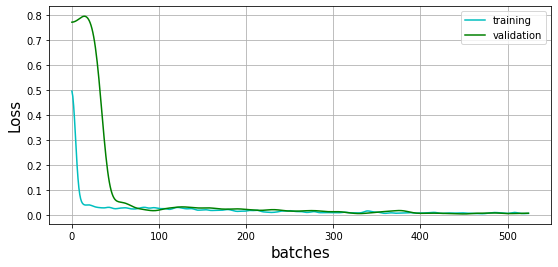

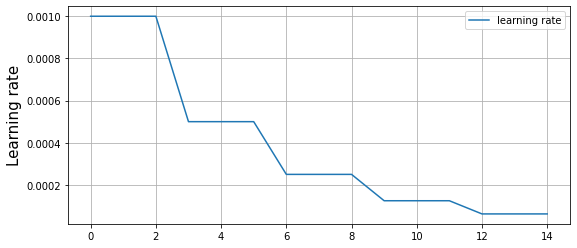

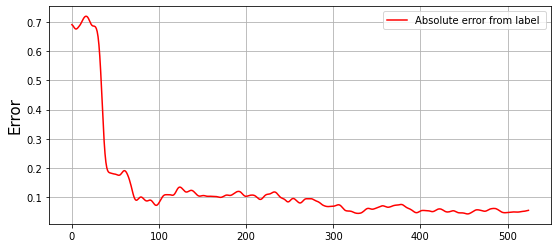

Time elapsed =  234.19935442200017  seconds


In [119]:
plt.rcParams["figure.figsize"] = (9,4)

config = { 
        "epochs" : 15,    
        "model" : model,      
        "train_loader" : train_loader, 
        "val_loader" : val_loader,
        "optimizer" : optimizer,
        "scheduler" : scheduler,
        "loss_function" : nn.MSELoss()
        }

losses = train_model(config)

### Saving the model

In [120]:
save_path = "/content/drive/My Drive/models/pre_clean_l1_estimate_lineage_population_resnet18.pt"
torch.save(model.state_dict(), save_path)

## Visualizing outputs from the now trained ResNet18

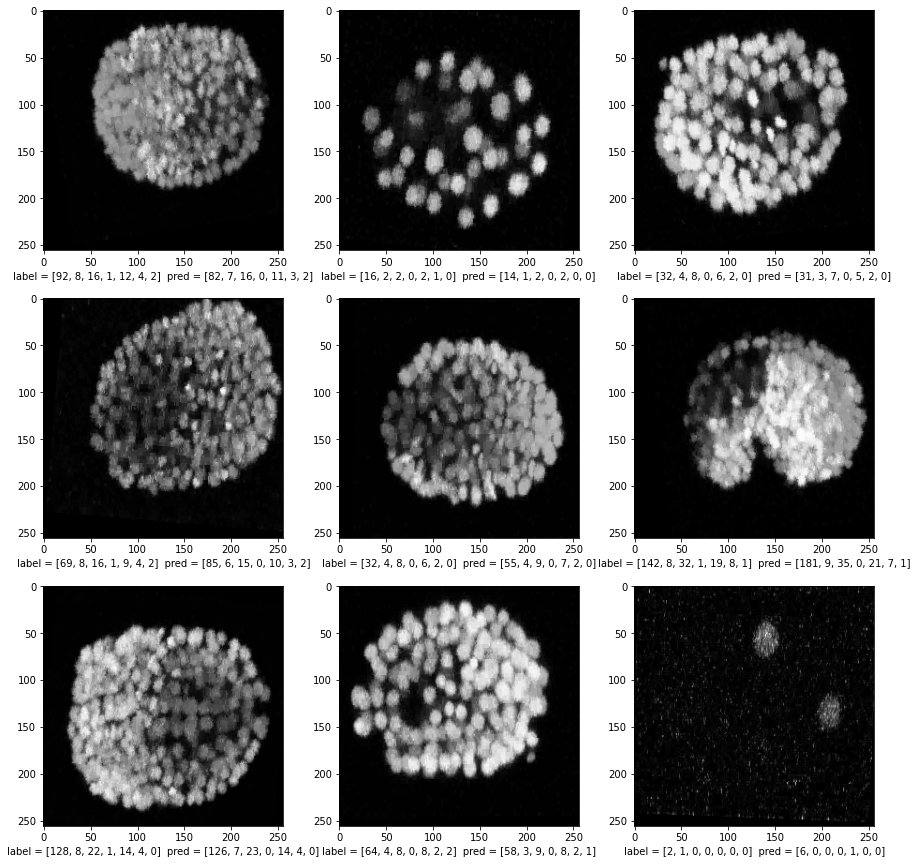

In [148]:
val_loader = DataLoader(dataset=test_dataset, batch_size= 16, shuffle = True)
batch = next(iter(val_loader))
show_preds(model , batch)

## REMOVING LOSSY FRAMES 

In [122]:
df_test = pd.read_csv("scaled_training_data.csv")

labels = df_test[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values
filenames = df_test.filenames.values
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469 entries, 0 to 1468
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          1469 non-null   float64
 1   E          1469 non-null   float64
 2   M          1469 non-null   float64
 3   P          1469 non-null   float64
 4   C          1469 non-null   float64
 5   D          1469 non-null   float64
 6   Z          1469 non-null   float64
 7   filenames  1469 non-null   object 
dtypes: float64(7), object(1)
memory usage: 91.9+ KB


In [123]:
mini_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize((256,256), interpolation = Image.NEAREST),
                                     transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5, 0.5)
])

In [124]:
def path_to_result(path, model):
    model.eval()
    im = cv2.imread(path)
    tensor = mini_transform(im).unsqueeze(0).cuda()
    res = model(tensor).detach().cpu().numpy().flatten()
    return res


def calc_abs_loss(pred,label):
    loss = np.sum(np.abs(pred-label))
    return loss

losses = []
preds = []
for i in tqdm(range(len(filenames))):
    pred = path_to_result(filenames[i], model )
    preds.append(pred)
    loss = calc_abs_loss(pred, labels[i])
    losses.append(loss)

losses = np.array(losses)

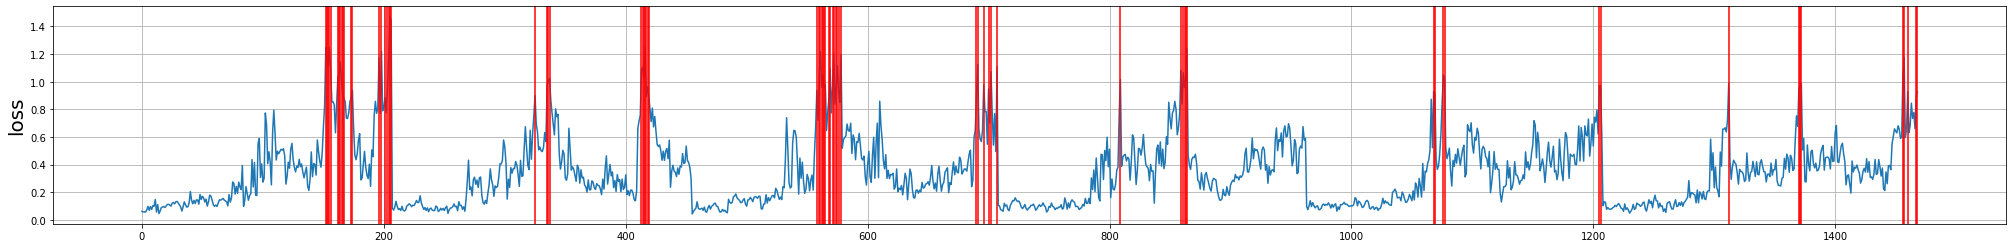

In [125]:
percentage = 5
num_bad = int((len(filenames)/100) * percentage)
indices_of_bad_pictures = (-losses).argsort()[:num_bad]

plt.rcParams["figure.figsize"] = (35,4)

plt.plot(losses)
plt.ylabel("loss", fontsize = 20)

for index in indices_of_bad_pictures:
    plt.axvline(x = index, c = "r")
plt.grid()
plt.show()

In [126]:
df_clean = df_test
df_clean = df_clean.drop(df_clean.index[indices_of_bad_pictures])
df_clean.to_csv("new_clean_training_data.csv")
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1396 entries, 0 to 1466
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          1396 non-null   float64
 1   E          1396 non-null   float64
 2   M          1396 non-null   float64
 3   P          1396 non-null   float64
 4   C          1396 non-null   float64
 5   D          1396 non-null   float64
 6   Z          1396 non-null   float64
 7   filenames  1396 non-null   object 
dtypes: float64(7), object(1)
memory usage: 98.2+ KB


## re train on clean images 

In [127]:
full_dataset = ImageDataset(labels_csv_path = "new_clean_training_data.csv",
                         augmentation = Compose([ 
                                                    VerticalFlip(p=0.5),
                                                    HorizontalFlip(p=0.5),
                                                    ]),
                            transform = transforms.Compose([    
                                                            transforms.ToPILImage(),
                                                            transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                            torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                            ToTensor(),
                                                            transforms.Normalize(0.5, 0.5, 0.5)
                                                            ]),
                            RGB = True ## set to true for ResNet
                             )

train_size = int(0.8* len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 16, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")


18 batches 
18  batches 


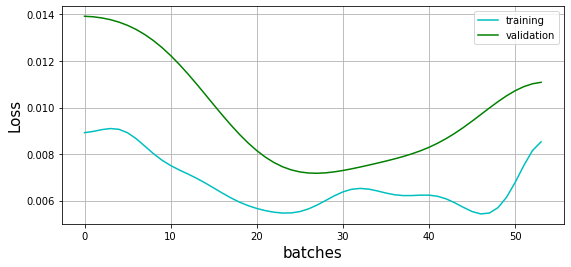

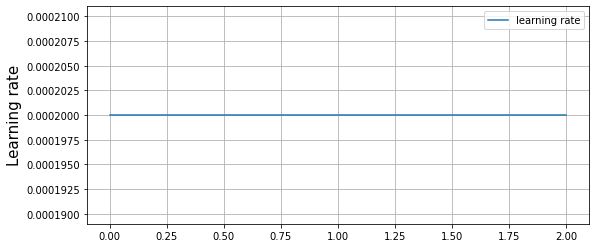

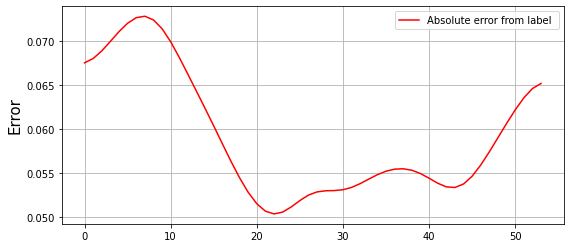

Time elapsed =  42.06094851099988  seconds


In [129]:
plt.rcParams["figure.figsize"] = (9,4)
optimizer = optim.Adam(model.parameters(), lr = 0.0002) 


config = { 
        "epochs" : 3,    
        "model" : model,      
        "train_loader" : train_loader, 
        "val_loader" : val_loader,
        "lr" : 0.001,
        "optimizer" : optimizer,
        "scheduler" : scheduler,
        "loss_function" : nn.MSELoss()
        }

losses = train_model(config)

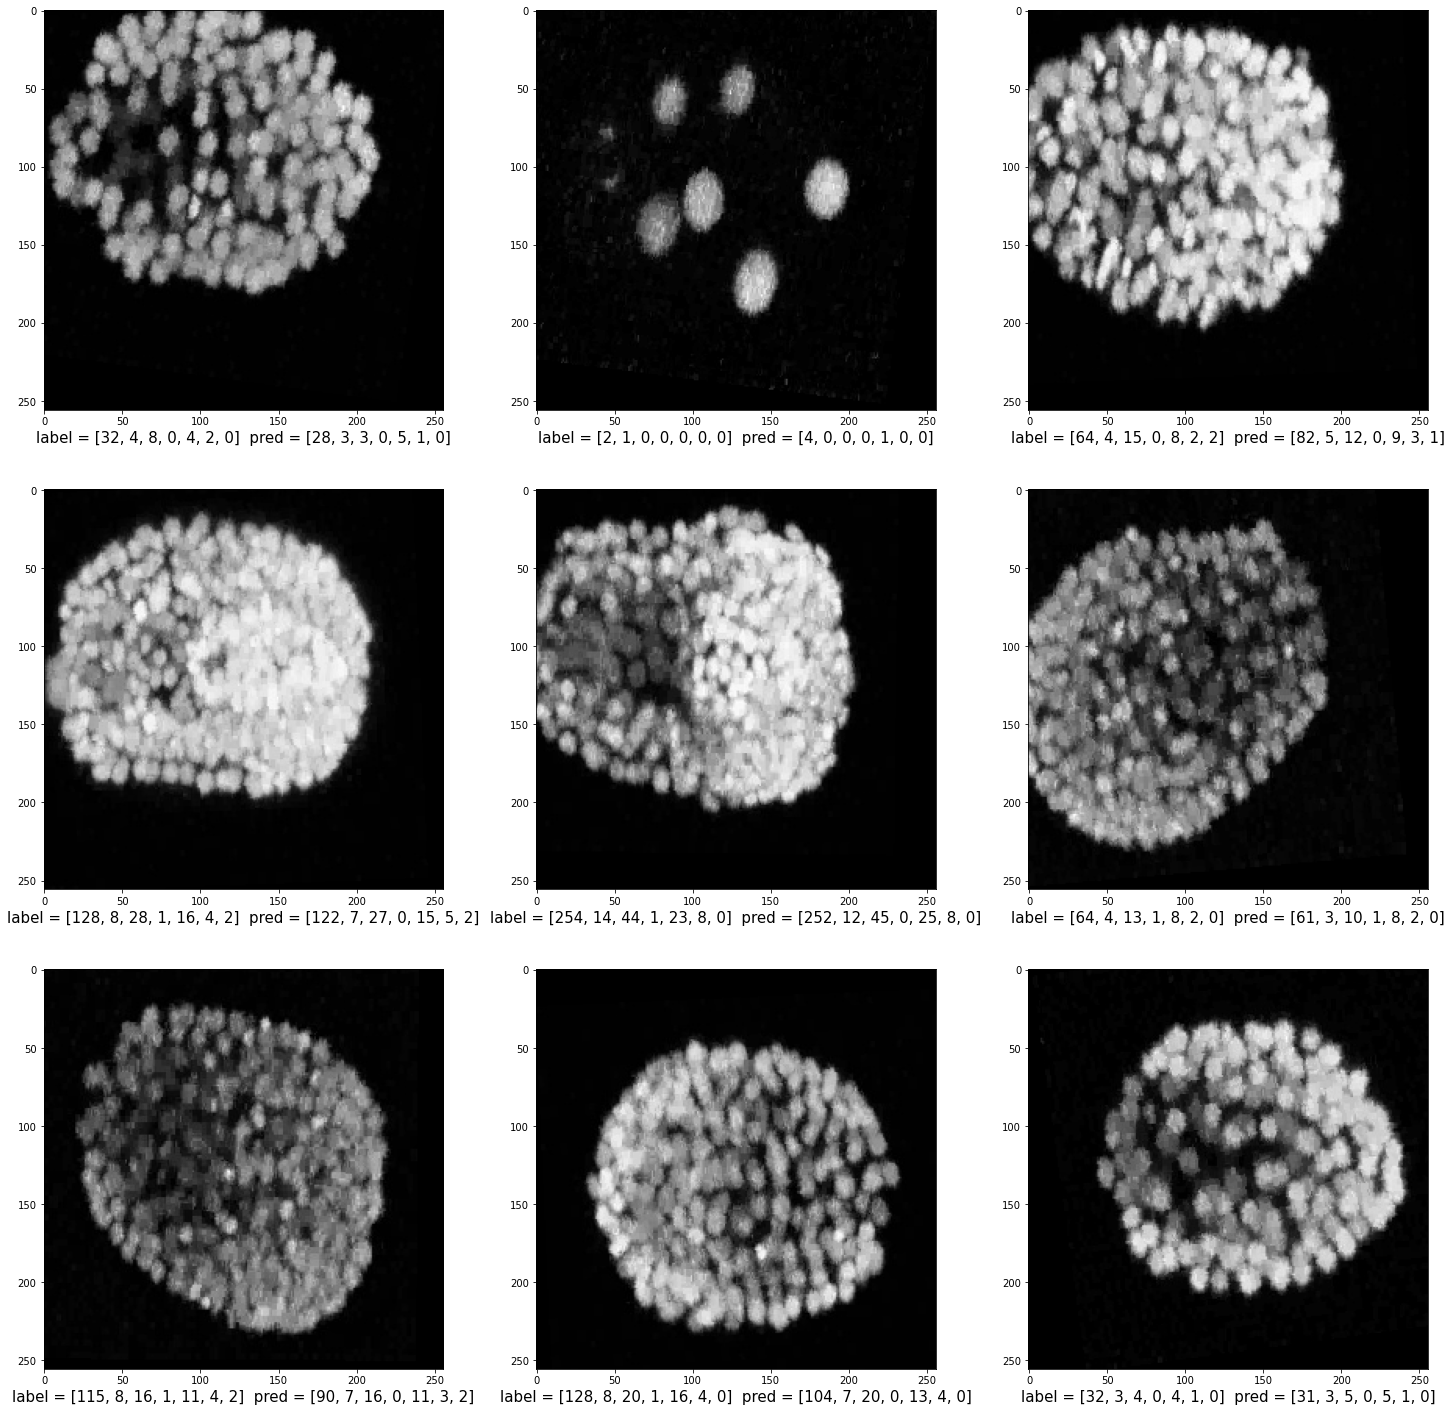

In [130]:
val_loader = DataLoader(dataset=test_dataset, batch_size= 16, shuffle = True)
batch = next(iter(val_loader))
show_preds(model , batch)

In [159]:
save_path = "/content/drive/My Drive/models/working_real_well_clean_data_estimate_lineage_population_resnet18.pt"
torch.save(model.state_dict(), save_path)

## Loading up the trained model further inferences 

In [ ]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [132]:
df_test = pd.read_csv("scaled_training_data.csv")
look_for_tag = "20090701_tbx-11_RW10249_L1"

df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)].head(220)
df_single_cell.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 206
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          207 non-null    float64
 1   E          207 non-null    float64
 2   M          207 non-null    float64
 3   P          207 non-null    float64
 4   C          207 non-null    float64
 5   D          207 non-null    float64
 6   Z          207 non-null    float64
 7   filenames  207 non-null    object 
dtypes: float64(7), object(1)
memory usage: 14.6+ KB


In [133]:
df_single_cell.head()
# print(df_single_cell.info())

,A,E,M,P,C,D,Z,filenames
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,frames/20090701_tbx-11_RW10249_L1/1.jpg
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,frames/20090701_tbx-11_RW10249_L1/2.jpg
2,0.003745,0.0,0.0,0.0,0.0,0.0,0.0,frames/20090701_tbx-11_RW10249_L1/3.jpg
3,0.003745,0.0,0.0,0.0,0.0,0.0,0.0,frames/20090701_tbx-11_RW10249_L1/4.jpg
4,0.003745,0.0,0.0,0.0,0.0,0.0,0.0,frames/20090701_tbx-11_RW10249_L1/5.jpg


In [134]:
data = scaler.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)

In [135]:
real_time_plots = []
for i in range(len(df_single_cell.columns[1:])):
    real_time_plots.append(data[:,i])

## Comparing real v/s "predicted" data
 We now showed the model all the frames from one single video and plotted it's population predictions. We then compared these predictions with the metadata of the video file. 

In [136]:
preds = []
filenames = df_single_cell.filenames.values
for i in range (len(filenames)):

    image = cv2.imread(filenames[i])
   
    tensor = mini_transform(image).unsqueeze(0).cuda()
    pred = model(tensor).cpu().detach().numpy().flatten()
    preds.append(pred)
    
preds = scaler.inverse_transform(np.array(preds)).astype(np.uint8)



In [137]:
generated_time_plots = []
for i in range(len(df_single_cell.columns[1:])):
    generated_time_plots.append(preds[:,i])

## It can be seen how the model's predictions "hover" around the real values
The model was not able to give accurate predictions on the earlier stages of the embryo for the "A" lineage probablu because of the random noise in the frames, this needs a fix. 

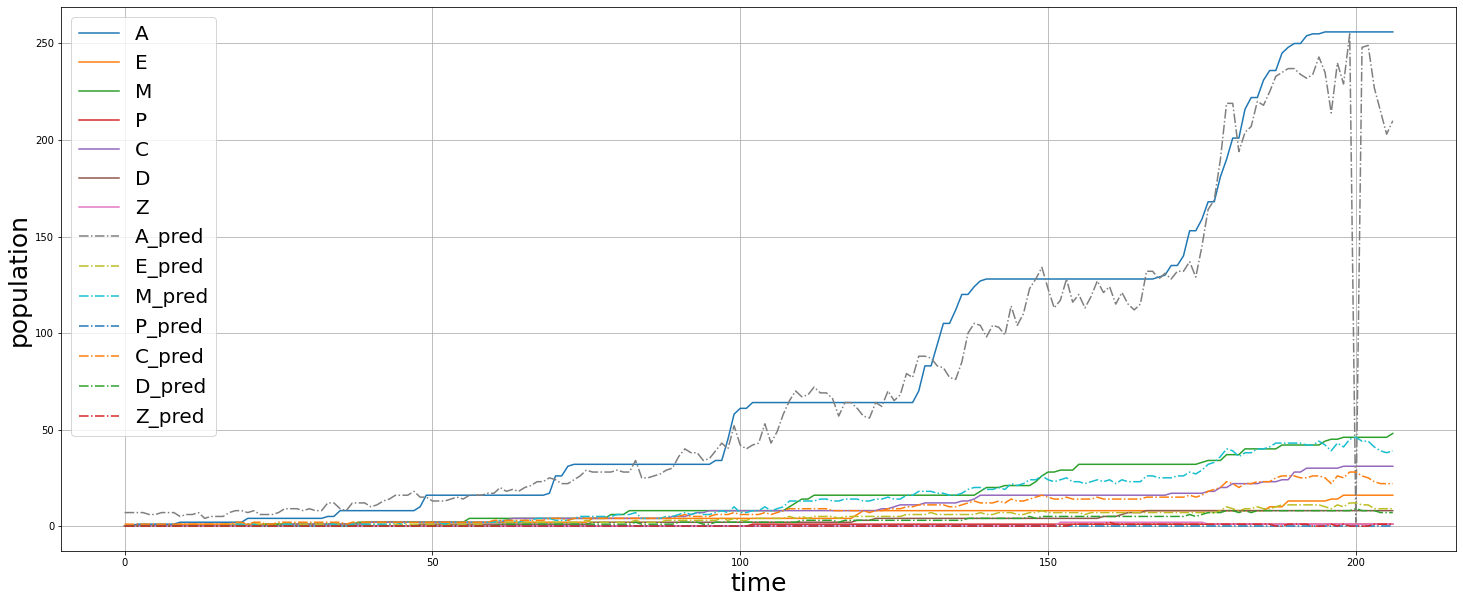

In [150]:
plt.rcParams['figure.figsize'] =25, 10

for i in range(len(real_time_plots)):
    plt.plot(real_time_plots[i], label = df_single_cell.columns[:-1][i] )


for i in range(len(generated_time_plots)):
    plt.plot(generated_time_plots[i], label = df_single_cell.columns[:-1][i] + "_pred", linestyle = "-." )

plt.xlabel("time", fontsize = 25)
plt.ylabel("population", fontsize = 25)
plt.legend(fontsize = 20)
plt.grid()

In [157]:
def researcher_vs_model(look_for_tag):

    df_test = pd.read_csv("scaled_training_data.csv")

    df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)].head(220)
    data = scaler.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
    real_time_plots = []
    for i in range(len(df_single_cell.columns[1:])):
        real_time_plots.append(data[:,i])


    preds = []
    filenames = df_single_cell.filenames.values
    for i in range (len(filenames)):

        image = cv2.imread(filenames[i])
    
        tensor = mini_transform(image).unsqueeze(0).cuda()
        pred = model(tensor).cpu().detach().numpy().flatten()
        preds.append(pred)
        
    preds = scaler.inverse_transform(np.array(preds)).astype(np.uint8)

    generated_time_plots = []
    for i in range(len(df_single_cell.columns[1:])):
        generated_time_plots.append(preds[:,i])

    plt.rcParams['figure.figsize'] =25, 10

    for i in range(len(real_time_plots)):
        plt.plot(real_time_plots[i], label = df_single_cell.columns[:-1][i] )


    for i in range(len(generated_time_plots)):
        plt.plot(generated_time_plots[i], label = df_single_cell.columns[:-1][i] + "_pred", linestyle = "--", linewidth = 2 )

    plt.xlabel("time", fontsize = 25)
    plt.ylabel("population", fontsize = 25)
    plt.legend(fontsize = 20)
    plt.grid()
    plt.show()

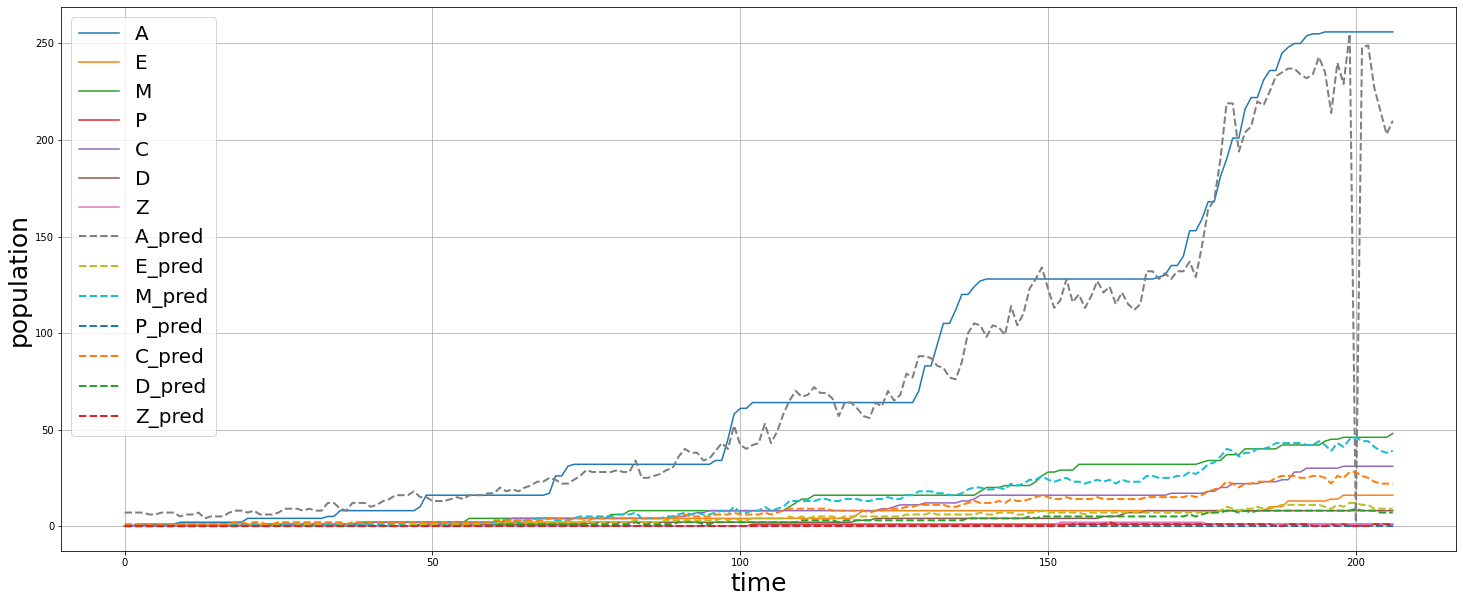

20090701_tbx-11_RW10249_L1


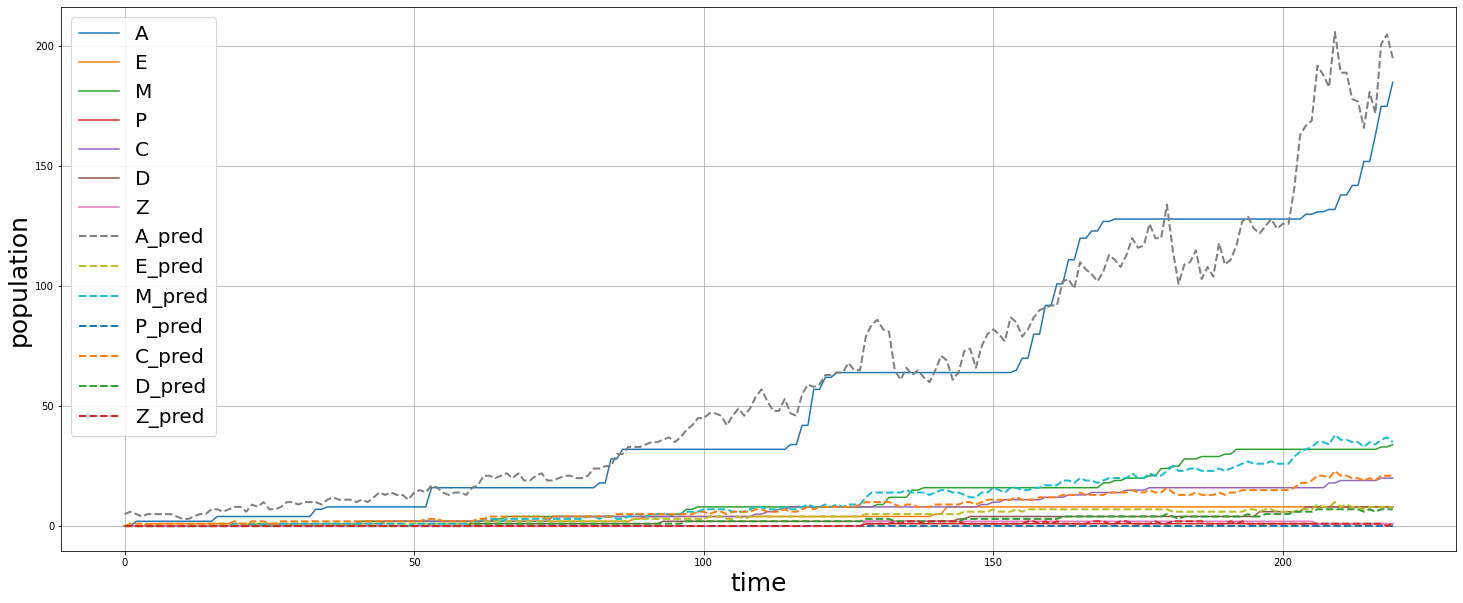

20080822_ceh-36b4_L1


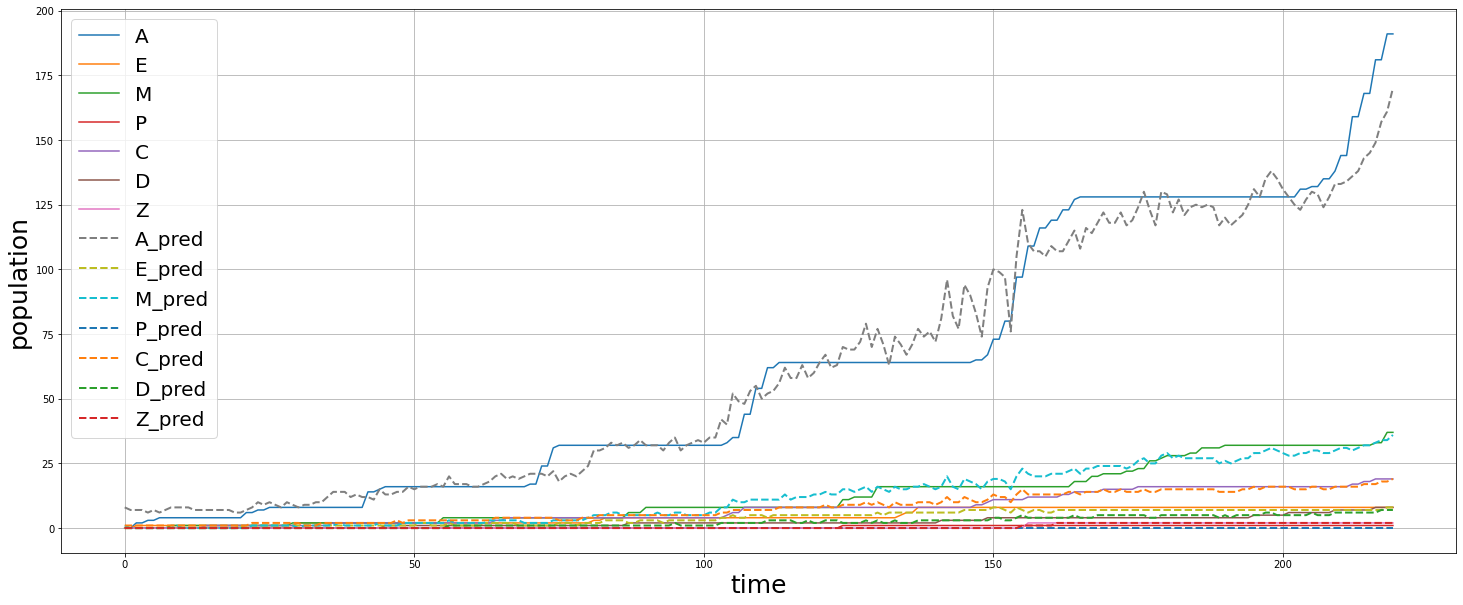

20090309_F39B2_1_7_L1


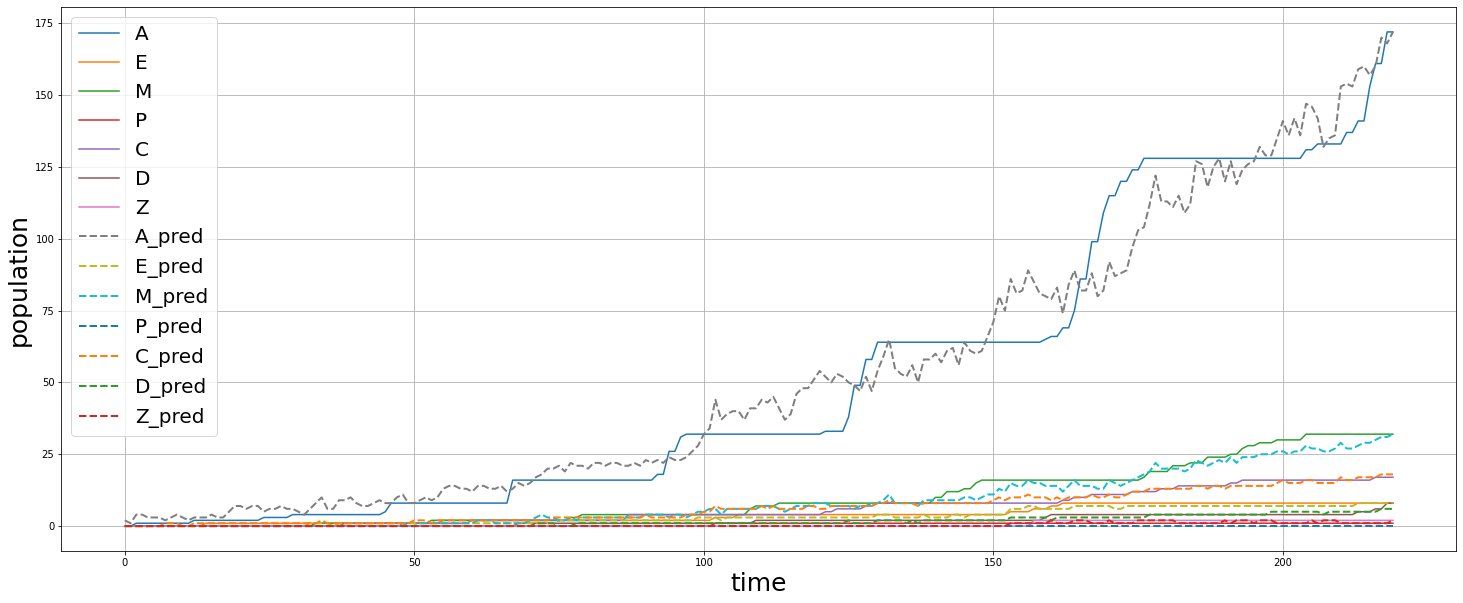

20081010_ceh-14_8F2_14_L1


In [158]:
clean_tags = ['20071210_rw10029_norfpxx', 
              '20090701_tbx-11_RW10249_L1',
              '20080822_ceh-36b4_L1', 
              '030906_dyf7red', 
              '20090309_F39B2_1_7_L1',
              '20080305_c50f7_5_7',
              '20070801_hnd-1_F396',
              '20081010_ceh-14_8F2_14_L1', 
              ]
for tag in clean_tags:
    try:
        researcher_vs_model(tag)
        print(tag)
    except:
        pass

## creating an animation to visualize the preds 

In [242]:
def generate_animation_frames(look_for_tag):

    df_test = pd.read_csv("scaled_training_data.csv")

    df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)].head(220)
    data = scaler.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
    real_time_plots = []
    for i in range(len(df_single_cell.columns[1:])):
        real_time_plots.append(data[:,i])


    preds = []
    filenames = df_single_cell.filenames.values
    for i in range (len(filenames)):

        image = cv2.imread(filenames[i])
    
        tensor = mini_transform(image).unsqueeze(0).cuda()
        pred = model(tensor).cpu().detach().numpy().flatten()
        preds.append(pred)
        
    preds = scaler.inverse_transform(np.array(preds)).astype(np.uint8)

    generated_time_plots = []

    for i in range(len(df_single_cell.columns[1:])):
        generated_time_plots.append(preds[:,i])


    for i in range(len(real_time_plots[0])):
        fig, ax = plt.subplots(1,2, figsize = (32, 12))


        for j in range(len(real_time_plots)):
            ax.flat[1].plot(real_time_plots[j][:i], label = df_single_cell.columns[:-1][j] )
            ax.flat[1].plot(generated_time_plots[j][:i], label = df_single_cell.columns[:-1][j] + "_pred", linestyle = "--", linewidth = 2 )
            ax.flat[1].grid()
            ax.flat[1].legend(fontsize = 20)

        im = cv2.imread(filenames[i], 0)
        ax.flat[0].imshow(im)

        savename = "animation/" + str(i) + ".png"
        fig.savefig(savename)
        clear_output()



In [243]:
!mkdir animation

mkdir: cannot create directory ‘animation’: File exists


In [ ]:
generate_animation_frames("20080822_ceh-36b4_L1")

In [223]:
len(os.listdir("animation"))

220

In [245]:
names = [ "animation/" + str(i) + ".png" for i in range (0, 220, 4)]
images = []
for n in names:
    frame = Image.open(n)
    images.append(frame)
print(len(images))

55


In [247]:
images[0].save('visualize_preds_slow_fine.gif',
               save_all=True,
               append_images=images[1:],
               duration=50,
               loop=0)

In [ ]:
!zip -r save_frames.zip animation/